生物気象観測

In [11]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

def add_project_root(marker="project_paths.py") -> Path:
    p = Path.cwd().resolve()
    for d in [p, *p.parents]:
        if (d / marker).exists():
            sys.path.insert(0, str(d))
            return d
    raise FileNotFoundError(f"Could not find {marker} from cwd={p}")

PROJECT_ROOT = add_project_root()
print("Project root:", PROJECT_ROOT)

from project_paths import ROOT as PROJECT, JMA_DATA, OUT, FIG, TAB, REP, CFG
from project_paths import OUT
#out_dir = OUT / "JMA_data"
from meteo_lib.core import getBlock, get_HourlyData, get_10minData
from meteo_lib.paths import JMA_DATA, JMA_GPV_DATA, ERA5_DATA, CACHE_DIR

print("Data root:",JMA_DATA)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Project root: /Users/takumi/Projects/meteo-analysis/JMA
Data root: /Users/takumi/Projects/MetData/JMA


In [12]:
import numpy as np
import pandas as pd
import math
from datetime import datetime, timedelta, date, time
import calendar
import os
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["font.family"] = "Hiragino Sans"   # 例：Noto Sans CJK JP でも可
mpl.rcParams["axes.unicode_minus"] = False    # －が豆腐になるのを回避
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FuncFormatter, MultipleLocator

from metpy.units import units
from metpy.calc import dewpoint_from_relative_humidity
from IPython.display import display 

In [13]:
def datetime_value(x, column_value):

    year = column_value  # 本来の年
    #  year = 2000  # 図化のため2000年に揃える
    if not np.isnan(x): x = int(x)
    #  print('ｘ ', year, x)
    if pd.notna(x):  # 欠測値には0が入力されている
        mon, day = np.divmod(x, 100)
#        print(mon, day)
        date_string = f"{year}-{mon}-{day}"
        date = pd.to_datetime(date_string, format='%Y-%m-%d')
        return date
    else:
        return  pd.NaT

In [14]:
# 生物季節観測のcsvファイルを読み込む
def read_data(fn):
    cs1 = ['rm', '番号']
    cs2 = ['平年値', '最早値', '最晩値', '最早年', '最晩年']
    end_year = 2024

#    print(fn)
    title_row = pd.read_csv(fn, encoding='shift-jis', nrows=1, header=None).iloc[0,1]
    df = pd.read_csv(fn, header=1, encoding='shift-JIS',
                 usecols=lambda column: all(substring not in column for substring in cs1),
                 index_col='地点名')

    df = df.drop(columns=cs2)
    df = df.drop(df.columns[df.columns>str(end_year)], axis=1)
    df.index = df.index.str.strip()  # indexから空白文字を削除
    df = df.where(df>=100, other=np.nan)
#    display(df)

    for col in df.columns:
        if col=='1969': print('統計値', col, df[col].max(), df[col].min())
        if (df[col].median() < 1000) and (df[col] > 1000).any():
            df[col] = df[col].apply(datetime_value, args=(df[col].name,))
            df[col] = df[col] - timedelta(days=365)
#      print(col, df[col], "timedelta")
        else:
            df[col] = df[col]
            df[col] = df[col].apply(datetime_value, args=(df[col].name,))
#            print(col, df[col])

    df = df.transpose()  # 行と列を入れ替える
    df.index.name = '年'

    return df, title_row

In [27]:
fp = JMA_DATA / 'raw/生物季節観測'

subject = {'うめ開花':1, 'さくら開花':4, 'さくら満開':5, 'あじさい開花':9, 'すすき開花':11,
           'いちょう黄葉':13, 'いちょう落葉':14,'かえで紅葉':15,'かえで落葉':16, 'うぐいす初鳴':18,
           'つばめ初見':19, 'とのさまがえる初見':22, 'あぶらぜみ初鳴':25, 'りんご開花':91, 'みんみんぜみ初鳴':119}

sub = 'いちょう黄葉'
sub_no = str(subject[sub]).zfill(3)
fn = fp / f'{sub_no}{sub}.csv'
print("file name:", fn)
# DataFrameを読み込んで列名を変更し、連結する
df, title_row = read_data(fn)
display(df)

file name: /Users/takumi/Projects/MetData/JMA/raw/生物季節観測/013いちょう黄葉.csv
統計値 1969 1204.0 1013.0


地点名,稚内,留萌,旭川,網走,札幌,岩見沢,帯広,釧路,根室,室蘭,...,徳島,名瀬,与那国島,西表島,石垣島,宮古島,久米島,那覇,名護,南大東島
年,,,,,,,,,,,,,,,,,,,,,
1953,NaT,NaT,NaT,NaT,1953-10-15,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1954,NaT,NaT,NaT,1954-10-12,1954-10-26,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1955,NaT,NaT,NaT,1955-10-12,1955-11-02,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1956,NaT,NaT,NaT,NaT,1956-11-01,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1957,NaT,NaT,NaT,NaT,1957-11-02,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,NaT,NaT,NaT,NaT,2020-11-02,NaT,2020-10-31,NaT,NaT,NaT,...,2020-12-08,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2021,NaT,NaT,NaT,NaT,2021-10-29,NaT,2021-10-29,NaT,NaT,NaT,...,2021-12-02,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2022,NaT,NaT,NaT,NaT,2022-11-04,NaT,2022-11-06,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [28]:
def to_refdate(s: pd.Series, ref_year: int) -> pd.Series:
    # 入力をまず datetime に統一（object混在対策）
    s = pd.to_datetime(s, errors="coerce")
    mask = s.notna()

    # いったん全NaTの Series を用意
    out = pd.Series(pd.NaT, index=s.index, dtype="datetime64[ns]")

    # 有効値のみ、月日を取り出して基準年で生成
    if mask.any():
        out.loc[mask] = pd.to_datetime({
            "year":  np.full(mask.sum(), ref_year, dtype=int),
            "month": s.loc[mask].dt.month,
            "day":   s.loc[mask].dt.day
        }, errors="raise")  # ref_yearが平年のとき2/29でエラーにしたいなら "raise"
    return out

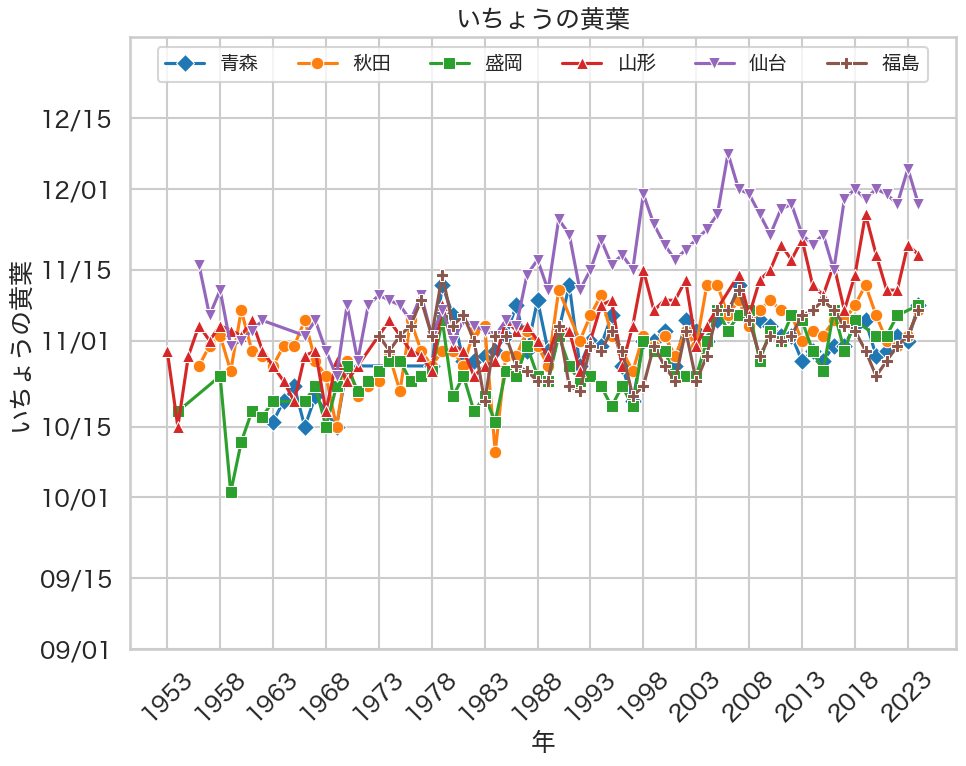

In [31]:
REF_YEAR = 2001

import seaborn as sns

place = ('青森', '秋田', '盛岡', '山形', '仙台', '福島')
fig = plt.figure(figsize=(10,8), tight_layout=True)
sns.set(style='whitegrid', context='talk', font_scale=1.0, font='Hiragino Sans')
ax1 = fig.add_subplot(1,1,1)
month_min, month_max = 9, 12
days = calendar.monthrange(REF_YEAR, month_max)[1]
y_min, y_max = f'{REF_YEAR}/{month_min}/1', f'{REF_YEAR}/{month_max}/{days}'
y_span = pd.to_datetime([y_min, y_max])
ax1.set_ylim(y_span)
y_df = pd.DataFrame({p: to_refdate(df[p], REF_YEAR) for p in place})
#print(y_df)

markers = ["D", "o", "s", "^", "v", "P"]   # 好きに増やせる
colors  = ["tab:blue", "tab:orange", "tab:green", 
           "tab:red", "tab:purple", "tab:brown"]
for p, m, c in zip(place, markers, colors):
    sns.lineplot(
        x=y_df.index, y=y_df[p], 
        linestyle='-', color=c,
        marker=m, label=p, ax=ax1)

ax1.set(title=title_row, xlabel='年', ylabel=title_row)
plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

plt.xticks(df.index[::5])  #　x軸ラベルの表示間隔を5に指定
plt.xticks(rotation=45)  # ラベルを45度回転させる

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, ncol=len(labels), loc="upper center", fontsize=14)

#plt.legend()
plt.savefig(OUT / f'{fp}{sub}.png')
plt.show()

/Users/takumi/Projects/MetData/JMA/raw/生物季節観測
統計値 1969 1201.0 1002.0
統計値 1969 1227.0 1027.0
df_long         年       date subject    refdate
0    1953        NaT   かえで紅葉        NaT
1    1954        NaT   かえで紅葉        NaT
2    1955        NaT   かえで紅葉        NaT
3    1956 1956-10-25   かえで紅葉 2001-10-25
4    1957 1957-10-28   かえで紅葉 2001-10-28
..    ...        ...     ...        ...
139  2020 2020-11-28   かえで落葉 2001-11-28
140  2021 2021-12-01   かえで落葉 2001-12-01
141  2022 2022-11-29   かえで落葉 2001-11-29
142  2023 2023-12-08   かえで落葉 2001-12-08
143  2024 2024-12-05   かえで落葉 2001-12-05

[144 rows x 4 columns]
仙台_かえで紅葉_かえで落葉.csv


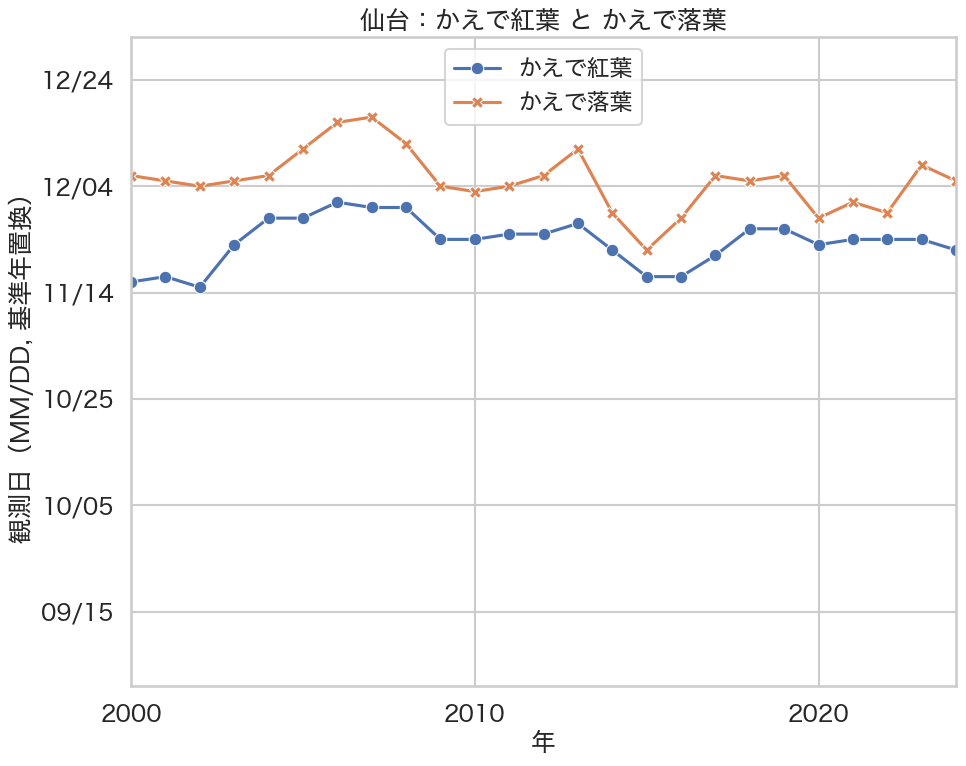

In [41]:
# ===== 入力パラメータ =====
REF_YEAR = 2001
place    = '仙台'
sub      = ('かえで紅葉', 'かえで落葉')
#sub      = ('さくら開花', 'あじさい開花')
subject  = {'うめ開花':1, 'さくら開花':4, 'さくら満開':5, 'あじさい開花':9, 'すすき開花':11,
            'いちょう黄葉':13, 'いちょう落葉':14,'かえで紅葉':15,'かえで落葉':16, 'うぐいす初鳴':18,
            'つばめ初見':19, 'とのさまがえる初見':22, 'あぶらぜみ初鳴':25, 'りんご開花':91, 'みんみんぜみ初鳴':119}

fp = JMA_DATA / 'raw/生物季節観測'
print(fp)

# === 入力CSVパス ===
sub_no_lst = [str(subject[s]).zfill(3) for s in sub]
fn_lst = [fp / f"{no}{name}.csv" for no, name in zip(sub_no_lst, sub)]

# === 読み込み（read_data は (df, title) を返す想定：列=地点名, 行=年, subject列を付ける） ===
parts = []
for name, path in zip(sub, fn_lst):
    df_i, title_i = read_data(path)      # df_i: index=年, columns=地点名, 値=日付
    ser_place = df_i[place].rename("date")     # 1地点だけ取り出す → Series
    tmp = ser_place.to_frame().reset_index().rename(columns={"index": "年"})
    tmp["subject"] = name
    parts.append(tmp)

#print("parts:", parts)

df_long = pd.concat(parts, ignore_index=True)  # 列: 年, date, subject

# 年をx、同じ年の「月日だけ」をREF_YEARにそろえたdateをyとして描く
df_long["refdate"] = to_refdate(df_long["date"], REF_YEAR)
print("df_long", df_long)

fn = f"{place}_{sub[0]}_{sub[1]}.csv"
print(fn)
df_long.to_csv(OUT / fn, index=False)

# === プロット ===
sns.set(style='whitegrid', context='talk')
plt.rcParams['font.family'] = 'Hiragino Sans'

fig, ax = plt.subplots(figsize=(10, 8))
df_long['年'] = pd.to_numeric(df_long['年'], errors='coerce')
#print(df_long.dtypes)
ax.set_xlim(2000, 2024)
ax.set_xticks(range(2000,2024,10))
month_min, month_max = 9, 12
days = calendar.monthrange(REF_YEAR, month_max)[1]
y_min = pd.to_datetime([f'{REF_YEAR}/{month_min}/1']),
y_max = pd.to_datetime([f'{REF_YEAR}/{month_max}/{days}']) + timedelta(days=1)
ax.set_ylim(y_min, y_max)
#ax.set_ylim(pd.to_datetime([f'{REF_YEAR}/{month_min}/1', f'{REF_YEAR}/{month_max}/{days}']))
sns.lineplot(
    data=df_long.sort_values(["subject", "年"]),
    x="年", y="refdate", hue="subject", style="subject",
    markers=True, dashes=False, ax=ax
)

ax.yaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax.set_title(f"{place}：{sub[0]} と {sub[1]}")
ax.set_xlabel("年"); ax.set_ylabel("観測日（MM/DD, 基準年置換）")
#sns.move_legend(ax, "upper center", bbox_to_anchor=(0.5, 1.12), ncol=len(sub), frameon=False)
sns.move_legend(ax, "upper center", title=None)
plt.tight_layout()
plt.show()


In [35]:
import pandas as pd

# まず安全に datetime 化（既に datetime ならこの行は不要）
#df['refdate'] = pd.to_datetime(df['refdate'], errors='coerce')

# 年×subject を横持ち（wide）に
w = (df_long
     .dropna(subset=['refdate'])        # refdate がない行は除外（任意）
     .pivot_table(index='年', columns='subject', values='refdate', aggfunc='first')
     .rename_axis(None, axis=1))

# 黄葉〜落葉の日数（落葉 - 黄葉）
w[f'{sub[0]}-{sub[1]}_日数'] = (w.get(sub[1]) - w.get(sub[0])).dt.days

# 欲しければ結果を tidy に戻すか、列を選んで表示
result = w[[sub[0], sub[1], f'{sub[0]}-{sub[1]}_日数']].reset_index()
print(result.head())


      年      かえで紅葉      かえで落葉  かえで紅葉-かえで落葉_日数
0  1956 2001-10-25        NaT             NaN
1  1957 2001-10-28 2001-11-10            13.0
2  1958 2001-11-01        NaT             NaN
3  1959 2001-11-20 2001-12-05            15.0
4  1960 2001-11-05 2001-11-26            21.0


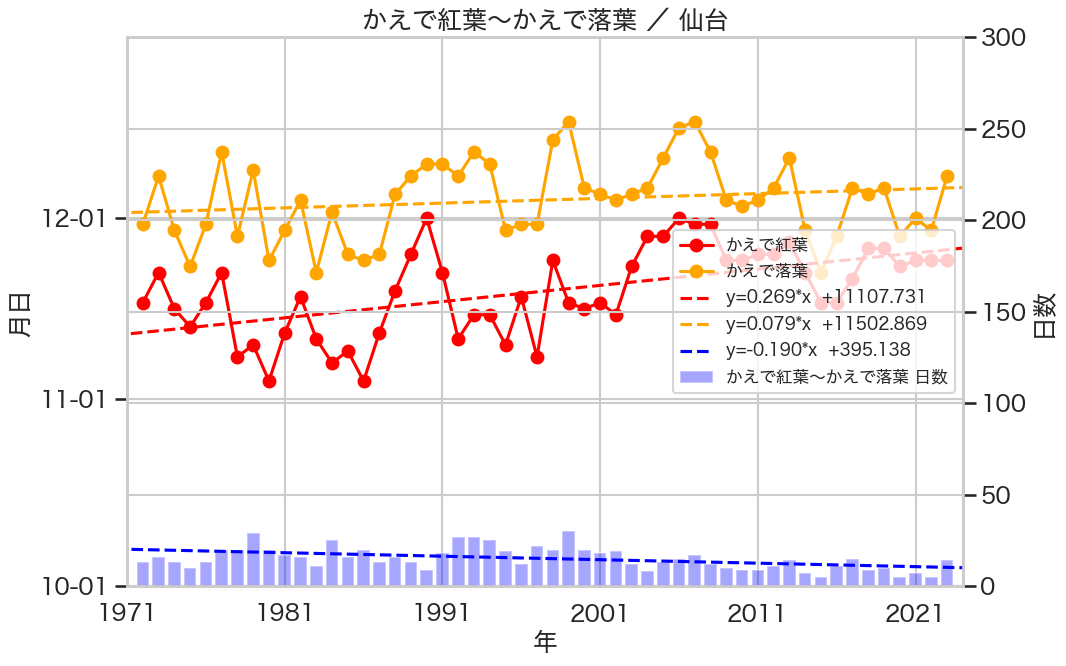

In [38]:
# 前提: w は index=年、列=['いちょう黄葉','いちょう落葉','黄葉→落葉_日数']
# いちょう黄葉・落葉は "2001-..-.." の refdate（日付）である想定
x_min, x_max = 1971, 2024

w = w.copy()
w[sub[0]] = pd.to_datetime(w[sub[0]], errors='coerce')
w[sub[1]] = pd.to_datetime(w[sub[1]], errors='coerce')

# y軸用に matplotlib の内部日付数値へ変換（NaTは除外マスクで処理）
y_koyo = mdates.date2num(w[sub[0]])
y_rakuyo = mdates.date2num(w[sub[1]])

fig, ax1 = plt.subplots(figsize=(11,7))

# --- 折れ線（左y軸：月日表示） ---
mask_k = (~w[sub[0]].isna()) & (w.index > x_min) & (w.index < x_max)
mask_r = (~w[sub[1]].isna()) & (w.index > x_min) & (w.index < x_max)

ax1.plot(w.index[mask_k], y_koyo[mask_k], marker='o', 
         color='red', label=sub[0])
ax1.plot(w.index[mask_r], y_rakuyo[mask_r], marker='o', 
         color='orange', label=sub[1])

ax1.set_xlabel('年')
ax1.set_ylabel('月日')
ax1.set_xlim(x_min, x_max)

ax1.set_xticks(range(x_min,x_max,10))
y1_min = pd.to_datetime(f'{REF_YEAR}/10/1')
y1_max = pd.to_datetime(f'{REF_YEAR}/12/31')
ax1.set_ylim(y1_min, y1_max)

a_k, b_k = np.polyfit(w.index[mask_k], y_koyo[mask_k], 1)
y_line_num_k = a_k * w.index + b_k
y_line_dt_k  = mdates.num2date(y_line_num_k)
ax1.plot(w.index, y_line_dt_k, linestyle="--", color="red",
         label=f'y={a_k:.3f}*x  {b_k:+.3f}')

a_r, b_r = np.polyfit(w.index[mask_r], y_rakuyo[mask_r], 1)
y_line_num_r = a_r * w.index + b_r
y_line_dt_r  = mdates.num2date(y_line_num_r)
ax1.plot(w.index, y_line_dt_r, linestyle="--", color="orange",
         label=f'y={a_r:.3f}*x  {b_r:+.3f}')

# y軸を月日表示にする（アンカー年は 2001 年想定）
ax1.yaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax1.yaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))  # 毎月1日
# 表示範囲（必要に応じて調整。秋〜冬に絞る例）
#ymin = mdates.date2num(pd.Timestamp('2001-09-01'))
#ymax = mdates.date2num(pd.Timestamp('2001-12-20'))
ax1.set_ylim(y1_min, y1_max)
#ax1.grid(True, axis='y', alpha=0.3)

# --- 第2y軸：棒グラフ（黄葉→落葉 日数） ---
ax2 = ax1.twinx()
y_d = w[f'{sub[0]}-{sub[1]}_日数']
#print(y_d[mask_k])
ax2.bar(w.index[mask_k], y_d[mask_k], color='blue',
        alpha=0.35, label=f'{sub[0]}〜{sub[1]} 日数')
ax2.set_ylabel('日数')
ax2.set_ylim(0, 300)

#x_num = mdates.date2num(w.index[mask_k])
x_num = w.index[mask_k]
y_num = y_d[mask_k]
a_d, b_d = np.polyfit(x_num, y_num, 1)
#x_all = mdates.date2num(w.index)
x_all = w.index
y_line = a_d * x_all + b_d
ax2.plot(w.index, y_line, linestyle="--", color="blue",
         label=f'y={a_d:.3f}*x  {b_d:+.3f}')

# 凡例（左右の軸ハンドルを結合）
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
leg = ax1.legend(h1+h2, l1+l2, fontsize=12,
                 loc='center right', title=None)  # タイトルは出さない

#plt.title(f'{sub[0]}・{sub[1]}（左：月日）と{sub[0]}-{sub[1]}期間（右：日数）')
plt.title(f'{sub[0]}〜{sub[1]} ／ {place}')
plt.tight_layout()
plt.savefig(OUT / f'{place}_{sub[0]}-{sub[1]}.png')
plt.show()